In [1]:
# 导入库
# ========== 基础工具 ==========
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

# ========== 可视化 ==========
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# ========== 数据预处理 ==========
from sklearn.preprocessing import (
    LabelEncoder, OrdinalEncoder, StandardScaler
)
from sklearn.model_selection import train_test_split, cross_val_score

# ========== 统计检验 ==========
from scipy.stats import chi2_contingency, pearsonr, zscore
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import HessianInversionWarning

# ========== 关联规则挖掘 ==========
from mlxtend.frequent_patterns import apriori, association_rules

# ========== 传统分类模型 ==========
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, ExtraTreesClassifier
)

# ========== 不平衡数据采样 ==========
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import EasyEnsembleClassifier

# ========== 模型评估 ==========
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc,
    classification_report, precision_recall_curve,
    average_precision_score
)

warnings.filterwarnings('ignore')

# 设置中文字体与图形风格
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style='whitegrid')
sns.set_palette("deep")

df=pd.read_csv('heart_2022_no_nans.csv')


# part1 数据预处理及初步EDA

#去重

In [4]:
df.duplicated().sum()
df.drop_duplicates(keep='first', inplace=True)
df.shape

(246013, 40)

#数据检视

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246013 entries, 0 to 246021
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      246013 non-null  object 
 1   Sex                        246013 non-null  object 
 2   GeneralHealth              246013 non-null  object 
 3   PhysicalHealthDays         246013 non-null  float64
 4   MentalHealthDays           246013 non-null  float64
 5   LastCheckupTime            246013 non-null  object 
 6   PhysicalActivities         246013 non-null  object 
 7   SleepHours                 246013 non-null  float64
 8   RemovedTeeth               246013 non-null  object 
 9   HadHeartAttack             246013 non-null  object 
 10  HadAngina                  246013 non-null  object 
 11  HadStroke                  246013 non-null  object 
 12  HadAsthma                  246013 non-null  object 
 13  HadSkinCancer              246013 

In [7]:
df.describe(include='O')

State     Sex GeneralHealth  \
count       246013  246013        246013   
unique          54       2             5   
top     Washington  Female     Very good   
freq         14998  127806         86996   

                                          LastCheckupTime PhysicalActivities  \
count                                              246013             246013   
unique                                                  4                  2   
top     Within past year (anytime less than 12 months ...                Yes   
freq                                               198144             191310   

        RemovedTeeth HadHeartAttack HadAngina HadStroke HadAsthma  ...  \
count         246013         246013    246013    246013    246013  ...   
unique             4              2         2         2         2  ...   
top     None of them             No        No        No        No  ...   
freq          131585         232578    231060    235902    209486  ...   

       ChestScan     RaceEthnicityCategory   AgeCategory AlcoholDrinkers  \
count     246013                    246013        246013          246013   
unique         2                         5            13               2   
top           No  White only, Non-Hispanic  Age 65 to 69             Yes   
freq      141818                    186327         28555          135299   

       HIVTesting FluVaxLast12 PneumoVaxEver  \
count      246013       246013        246013   
unique          2            2             2   
top            No          Yes            No   
freq       161513       131188        146128   

                                        TetanusLast10Tdap HighRiskLastYear  \
count                                              246013           246013   
unique                                                  4                2   
top     No, did not receive any tetanus shot in the pa...               No   
freq                                                81743           235437   

       CovidPos  
count    246013  
unique        3  
top          No  
freq     167297  

[4 rows x 34 columns]

In [8]:
print(df.iloc[:, 2:33].describe())

       PhysicalHealthDays  MentalHealthDays     SleepHours  HeightInMeters  \
count       246013.000000     246013.000000  246013.000000   246013.000000   
mean             4.119055          4.167292       7.021312        1.705150   
std              8.405803          8.102796       1.440698        0.106654   
min              0.000000          0.000000       1.000000        0.910000   
25%              0.000000          0.000000       6.000000        1.630000   
50%              0.000000          0.000000       7.000000        1.700000   
75%              3.000000          4.000000       8.000000        1.780000   
max             30.000000         30.000000      24.000000        2.410000   

       WeightInKilograms            BMI  
count      246013.000000  246013.000000  
mean           83.615522      28.668258  
std            21.323232       6.514005  
min            28.120000      12.020000  
25%            68.040000      24.270000  
50%            81.650000      27.460000  
75%

通过观察，发现这个数据集中没有缺失值，但通过观察数值型变量的分布特征，有如下发现：

BMI：均值28.67，标准差6.51，最大97.65，右偏（中位数27.46 <均值，最大值远超75%分位31.89）。

SleepHours：均值7.02，标准差1.44，范围1-24，异常值可能在两端（1或24小时不合理）。

PhysicalHealthDays, MentalHealthDays：均值≈4，最大30，75%分位仅3-4，右偏（许多值为0，少数高值）。

HeightInMeters：均值1.71，范围0.91-2.41，需检查极端值（如0.91米）。

WeightInKilograms：均值83.62，范围28.12-292.57，需检查高值（如292.57kg）。

下面先进行异常值处理

初步判断是：

BMI：>50或<15可能为异常值（基于之前估计，占比约0.39%）。

SleepHours：<3或>12可能不合理（1小时或24小时睡眠异常）。

PhysicalHealthDays, MentalHealthDays：30天可能为极端值，但需验证是否合理（可能为慢性病患者）。

HeightInMeters：<1.2或>2.2可能为错误（儿童或录入错误）。

WeightInKilograms：>200或<40可能为异常值。

下面采用IQR方法进行异常值处理

In [10]:
# 定义数值变量
numeric_cols = ['BMI', 'SleepHours', 'PhysicalHealthDays', 'MentalHealthDays', 
                'HeightInMeters', 'WeightInKilograms']

# 异常值处理（IQR + 医学合理性）
df_clean = df.copy()
for col in numeric_cols:
    Q1, Q3 = df_clean[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    if col == 'BMI': lower, upper = max(lower, 15), min(upper, 50)
    if col == 'SleepHours': lower, upper = max(lower, 3), min(upper, 12)
    if col == 'HeightInMeters': lower, upper = max(lower, 1.2), min(upper, 2.2)
    if col == 'WeightInKilograms': lower, upper = max(lower, 40), min(upper, 200)
    df_clean[col] = df_clean[col].clip(lower, upper)

# 变量清洗和合并分类
df1 = df_clean.copy()
df1['HadDiabetes'] = df1['HadDiabetes'].replace({
    'Yes': 'Yes',
    'Yes, but only during pregnancy (female)': 'Yes',
    'No': 'No',
    'No, pre-diabetes or borderline diabetes': 'No'
})
df1['TetanusLast10Tdap'] = df1['TetanusLast10Tdap'].replace({
    'Yes, received Tdap': 'Yes',
    'Yes, received tetanus shot but not sure what type': 'Yes',
    'Yes, received tetanus shot, but not Tdap': 'Yes',
    'No, did not receive any tetanus shot in the past 10 years': 'No'
})
df1['CovidPos'] = df1['CovidPos'].replace({
    'Yes': 'Yes',
    'Tested positive using home test without a health professional': 'Yes',
    'No': 'No'
})

# 有序编码
ordinal_cols = ['GeneralHealth', 'LastCheckupTime', 'RemovedTeeth', 
                'AgeCategory', 'SmokerStatus', 'ECigaretteUsage']
categories = [
    ['Poor', 'Fair', 'Good', 'Very good', 'Excellent'],
    ['Within past year (anytime less than 12 months ago)', '5 or more years ago', 
     'Within past 2 years (1 year but less than 2 years ago)', 'Within past 5 years (2 years but less than 5 years ago)'],
    ['None of them', '1 to 5', '6 or more, but not all', 'All'],
    ['Age 18 to 24', 'Age 25 to 29', 'Age 30 to 34', 'Age 35 to 39', 'Age 40 to 44', 'Age 45 to 49', 
     'Age 50 to 54', 'Age 55 to 59', 'Age 60 to 64', 'Age 65 to 69', 'Age 70 to 74', 'Age 75 to 79', 'Age 80 or older'],
    ['Never smoked', 'Former smoker', 'Current smoker - now smokes some days', 'Current smoker - now smokes every day'],
    ['Never used e-cigarettes in my entire life', 'Not at all (right now)', 'Use them some days', 'Use them every day']
]
encoder = OrdinalEncoder(categories=categories)
encoded_data = encoder.fit_transform(df1[ordinal_cols])

for i, col in enumerate(ordinal_cols):
    if col == 'AgeCategory':
        df1['AgeCategory_encoded'] = encoded_data[:, i]
    else:
        df1[col] = encoded_data[:, i]

# 二值字段01编码
binary_cols = ['PhysicalActivities', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 
               'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'DeafOrHardOfHearing', 
               'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 
               'DifficultyErrands', 'ChestScan', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 
               'HighRiskLastYear', 'HadDiabetes', 'TetanusLast10Tdap', 'CovidPos']
df1[binary_cols] = df1[binary_cols].replace({'No': 0, 'Yes': 1})


#总体样本中患心脏病的比例

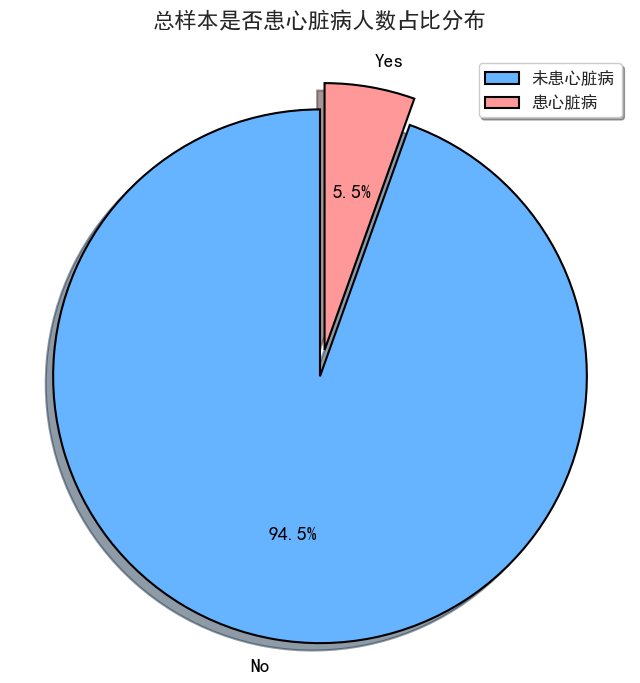

In [12]:
# 设置 Matplotlib 支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial']  # 优先 SimHei
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
# 创建饼图
plt.figure(figsize=(8, 8))
colors = ['#66b3ff', '#ff9999']  # 优化颜色：浅蓝色和浅红色，更柔和
explode = (0, 0.1)  # 突出“患心脏病”部分
wedgeprops = {'edgecolor': 'black', 'linewidth': 1.5, 'linestyle': '-'}  # 边缘线更明显
textprops = {'fontsize': 14, 'color': 'black', 'weight': 'bold'}  # 百分比文字样式

# 绘制饼图
df['HadHeartAttack'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    colors=colors, 
    explode=explode, 
    shadow=True, 
    startangle=90, 
    wedgeprops=wedgeprops, 
    textprops=textprops
)

# 设置标题和图例
plt.title('总样本是否患心脏病人数占比分布', fontsize=16, weight='bold', pad=20)
plt.axis('equal')  # 确保饼图为正圆
plt.legend(['未患心脏病', '患心脏病'], fontsize=12, loc='upper right', frameon=True, shadow=True)

# 移除 y 轴标签（饼图不需要）
plt.ylabel('')
# 显示图形
plt.show()

主要变量与心脏病相关性概览

=== 所有变量与心脏病发作相关性总结 ===
                           变量  类型  卡方检验 p 值  显著性    相关系数     p 值
0          PhysicalActivities  分类       0.0   显著     NaN     NaN
1              HadHeartAttack  分类       0.0   显著     NaN     NaN
2                   HadAngina  分类       0.0   显著     NaN     NaN
3                   HadStroke  分类       0.0   显著     NaN     NaN
4                   HadAsthma  分类       0.0   显著     NaN     NaN
5               HadSkinCancer  分类       0.0   显著     NaN     NaN
6                     HadCOPD  分类       0.0   显著     NaN     NaN
7       HadDepressiveDisorder  分类       0.0   显著     NaN     NaN
8            HadKidneyDisease  分类       0.0   显著     NaN     NaN
9                HadArthritis  分类       0.0   显著     NaN     NaN
10        DeafOrHardOfHearing  分类       0.0   显著     NaN     NaN
11    BlindOrVisionDifficulty  分类       0.0   显著     NaN     NaN
12    DifficultyConcentrating  分类       0.0   显著     NaN     NaN
13          DifficultyWalking  分类       0.0   显著     NaN     NaN
1

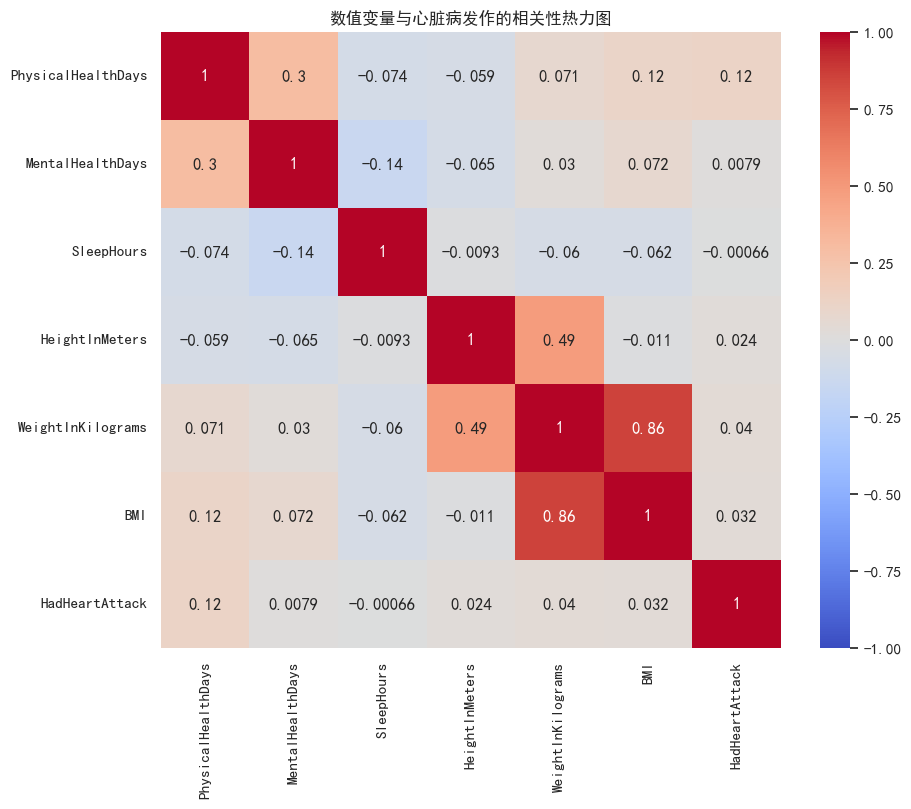

显著变量： ['PhysicalActivities', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'ChestScan', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'HighRiskLastYear', 'HadDiabetes', 'TetanusLast10Tdap', 'CovidPos', 'GeneralHealth', 'LastCheckupTime', 'RemovedTeeth', 'AgeCategory', 'SmokerStatus', 'ECigaretteUsage', 'PhysicalHealthDays', 'MentalHealthDays', 'HeightInMeters', 'WeightInKilograms', 'BMI']


In [14]:
from scipy.stats import chi2_contingency, pointbiserialr
# 所有分析变量
numeric_cols = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']
categorical_vars = binary_cols + ordinal_cols

# 初始化结果存储
results = []

# 卡方检验：分类变量与 HadHeartAttack
for var in categorical_vars:
    try:
        crosstab = pd.crosstab(df1[var], df1['HadHeartAttack'])
        chi2, p, dof, ex = chi2_contingency(crosstab)
        results.append({
            '变量': var,
            '类型': '分类',
            '卡方检验 p 值': p,
            '显著性': '显著' if p < 0.05 else '不显著'
        })
    except Exception as e:
        print(f"变量 {var} 卡方检验失败：{e}")

# 点二列相关：数值变量与 HadHeartAttack
for var in numeric_cols:
    try:
        corr, p = pointbiserialr(df1[var], df1['HadHeartAttack'])
        results.append({
            '变量': var,
            '类型': '数值',
            '相关系数': corr,
            'p 值': p,
            '显著性': '显著' if p < 0.05 else '不显著'
        })
    except Exception as e:
        print(f"变量 {var} 点二列相关失败：{e}")

# 转换为 DataFrame 并显示结果
results_df = pd.DataFrame(results)
print("=== 所有变量与心脏病发作相关性总结 ===")
print(results_df.round(4))

# 可视化数值变量相关性热力图
corr_cols = numeric_cols + ['HadHeartAttack']
corr_matrix = df1[corr_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('数值变量与心脏病发作的相关性热力图')
import os
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")  # 获取桌面路径
save_path = os.path.join(desktop_path, "可视化数值变量相关性热力图.png")  # 自定义文件名
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # dpi控制清晰度
plt.show()

# 可视化分类变量显著性
significant_vars = results_df[results_df['显著性'] == '显著']['变量'].tolist()
print("显著变量：", significant_vars)

发现如下两个问题：

1.所有分类变量的p值都极小，可能因样本量大（246013行），导致小差异也被检测为显著。下面结合实际效果大小（如Cramér’s V）评估关联强度。

2.数值变量和心脏病患病都有较为微弱的正相关关系（除了睡眠时长），因此下面只分析几个生活中常见的因素。

In [16]:
from scipy.stats import chi2_contingency

# 定义分类变量列表
categorical_vars = [
    'PhysicalActivities', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer',
    'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'DeafOrHardOfHearing',
    'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing',
    'DifficultyErrands', 'ChestScan', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
    'HighRiskLastYear', 'HadDiabetes', 'TetanusLast10Tdap', 'CovidPos',
    'GeneralHealth', 'LastCheckupTime', 'RemovedTeeth', 'AgeCategory_encoded', 'SmokerStatus', 'ECigaretteUsage'
]

# 定义 Cramér’s V 函数
def cramers_v(crosstab):
    chi2 = chi2_contingency(crosstab)[0]
    n = crosstab.sum().sum()
    r, k = crosstab.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# 初始化结果存储
v_results = []

# 计算分类变量的 Cramér’s V
for var in categorical_vars:
    if var != 'HadHeartAttack':  # 排除目标变量自身
        try:
            crosstab = pd.crosstab(df1[var], df1['HadHeartAttack'])
            cramer_v = cramers_v(crosstab)
            v_results.append({
                '变量': var,
                'Cramér’s V': cramer_v
            })
        except Exception as e:
            print(f"变量 {var} Cramér’s V 计算失败：{e}")

# 转换为 DataFrame 并按 Cramér’s V 降序排序
v_results_df = pd.DataFrame(v_results)
v_results_df = v_results_df.sort_values(by='Cramér’s V', ascending=False)

# 显示结果
print("=== 分类变量 Cramér’s V 总结（按值降序排列） ===")
print(v_results_df.round(4))

=== 分类变量 Cramér’s V 总结（按值降序排列） ===
                           变量  Cramér’s V
1                   HadAngina      0.4459
24              GeneralHealth      0.2005
27        AgeCategory_encoded      0.1795
2                   HadStroke      0.1771
26               RemovedTeeth      0.1686
15                  ChestScan      0.1677
12          DifficultyWalking      0.1599
21                HadDiabetes      0.1398
5                     HadCOPD      0.1332
19              PneumoVaxEver      0.1199
8                HadArthritis      0.1178
7            HadKidneyDisease      0.1093
9         DeafOrHardOfHearing      0.0976
28               SmokerStatus      0.0954
14          DifficultyErrands      0.0895
0          PhysicalActivities      0.0832
13  DifficultyDressingBathing      0.0830
16            AlcoholDrinkers      0.0742
10    BlindOrVisionDifficulty      0.0729
25            LastCheckupTime      0.0710
11    DifficultyConcentrating      0.0516
4               HadSkinCancer      0.0494

关键发现：  
1.HadAngina（0.4459）是心脏病发作的最强预测因子。  
2.GeneralHealth（0.2005）、AgeCategory_encoded（0.1795）、HadStroke（0.1771）等变量显示中等强度关联。  
3.SmokerStatus（0.0954）和AlcoholDrinkers（0.0742）关联较弱，需进一步分析其编码和影响。

# part2 心脏病诱因EDA分析——围绕不同年龄阶段的考察

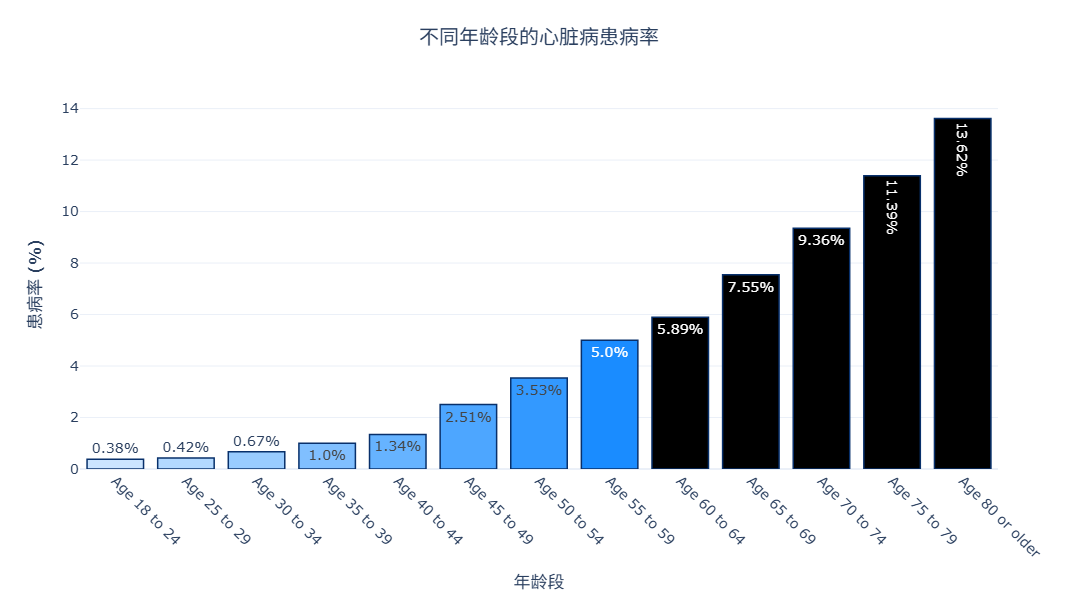

In [19]:
# 计算每个年龄段的心脏病患病率
heart_attack_by_age = df.groupby('AgeCategory')['HadHeartAttack'].apply(
    lambda x: (x == 'Yes').mean() * 100
).reset_index()
heart_attack_by_age.columns = ['AgeCategory', 'HadHeartAttack']

# 可视化
fig = go.Figure()

# 定义低饱和度渐变色
colors = ['rgb(204, 229, 255)', 'rgb(179, 217, 255)', 
          'rgb(153, 204, 255)', 'rgb(128, 191, 255)',
          'rgb(102, 179, 255)', 'rgb(77, 166, 255)',
          'rgb(51, 153, 255)', 'rgb(26, 140, 255)']

# 添加柱状图，使用渐变色
fig.add_trace(go.Bar(
    x=heart_attack_by_age['AgeCategory'],
    y=heart_attack_by_age['HadHeartAttack'],
    marker=dict(
        color=colors,
        line=dict(color='rgb(8,48,107)', width=1.5),
    ),
    text=heart_attack_by_age['HadHeartAttack'].round(2).astype(str) + '%',
    textposition='auto',
))

# 更新布局
fig.update_layout(
    title={
        'text': '不同年龄段的心脏病患病率',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='年龄段',
    yaxis_title='患病率 (%)',
    template='plotly_white',
    font=dict(size=14),
    showlegend=False,
    height=600,
    width=1000
)

# 更新x轴标签角度
fig.update_xaxes(tickangle=45)

fig.show()

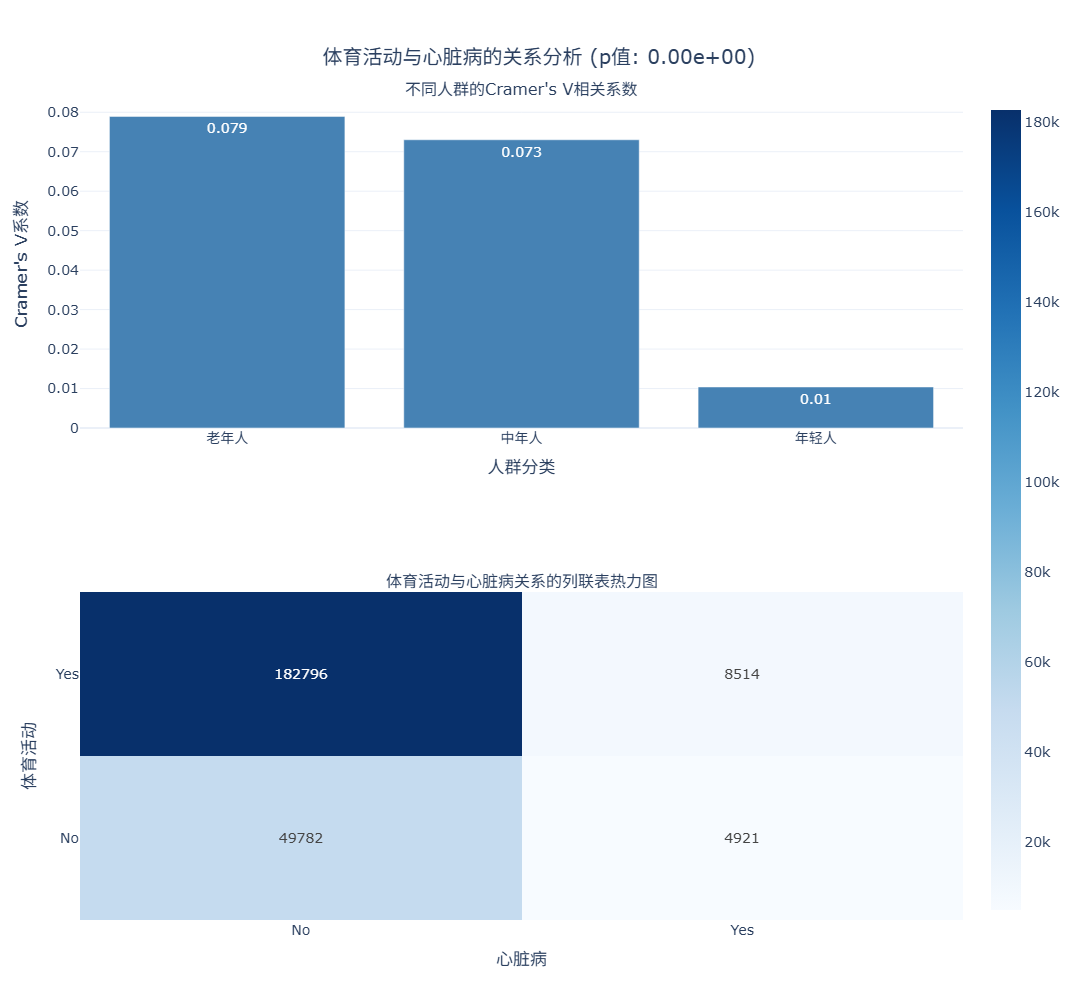

In [20]:
def get_distribution_category(age_category):
    if age_category in ['Age 60 to 64', 'Age 65 to 69', 'Age 70 to 74', 'Age 75 to 79', 'Age 80 or older']:
        return '老年人'
    elif age_category in ['Age 18 to 24', 'Age 25 to 29', 'Age 30 to 34']:
        return '年轻人'
    elif age_category in ['Age 35 to 39', 'Age 40 to 44', 'Age 45 to 49', 'Age 50 to 54', 'Age 55 to 59']:
        return '中年人'
df['人群分类'] = df['AgeCategory'].apply(get_distribution_category)
df.head()

# 计算Cramer's V系数
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

# 计算每个年龄组的Cramer's V系数
cramers_v_results = []
for group in df['人群分类'].unique():
    group_data = df[df['人群分类'] == group]
    confusion_matrix = pd.crosstab(group_data['PhysicalActivities'], group_data['HadHeartAttack'])
    v = cramers_v(confusion_matrix)
    cramers_v_results.append({
        '人群分类': group,
        'Cramer\'s V': v
    })

# 转换为DataFrame
cramers_v_df = pd.DataFrame(cramers_v_results)

# 创建热力图数据
heatmap_data = pd.crosstab(df['PhysicalActivities'], df['HadHeartAttack'])
chi2, p_value, dof, expected = chi2_contingency(heatmap_data)

# 创建子图
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('不同人群的Cramer\'s V相关系数', '体育活动与心脏病关系的列联表热力图'),
    vertical_spacing=0.2,
    specs=[[{"type": "bar"}], [{"type": "heatmap"}]]
)

# 添加Cramer's V柱状图
fig.add_trace(
    go.Bar(
        x=cramers_v_df['人群分类'],
        y=cramers_v_df['Cramer\'s V'],
        name='Cramer\'s V',
        marker_color='rgb(70, 130, 180)',
        text=cramers_v_df['Cramer\'s V'].round(3).astype(str),
        textposition='auto'
    ),
    row=1, col=1
)

# 添加热力图
fig.add_trace(
    go.Heatmap(
        z=heatmap_data.values,
        x=heatmap_data.columns,
        y=heatmap_data.index,
        colorscale='Blues',
        text=heatmap_data.values,
        texttemplate='%{text}',
        textfont={"size": 14},
        showscale=True
    ),
    row=2, col=1
)

# 更新布局
fig.update_layout(
    height=1000,
    width=1000,
    template='plotly_white',
    font=dict(size=14),
    showlegend=False,
    title={
        'text': f'体育活动与心脏病的关系分析 (p值: {p_value:.2e})',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

# 更新y轴标题
fig.update_yaxes(title_text='Cramer\'s V系数', row=1, col=1)
fig.update_yaxes(title_text='体育活动', row=2, col=1)

# 更新x轴标题
fig.update_xaxes(title_text='人群分类', row=1, col=1)
fig.update_xaxes(title_text='心脏病', row=2, col=1)

# 保存图表
fig.show()

不同人群中不同睡眠分类的占比：
  人群分类  睡眠分类        占比
0  中年人  正常睡眠  0.821658
1  中年人   低睡眠  0.126099
2  中年人   长睡眠  0.052243
3  年轻人  正常睡眠  0.813982
4  年轻人   低睡眠  0.116800
5  年轻人   长睡眠  0.069218
6  老年人  正常睡眠  0.808806
7  老年人   长睡眠  0.106618
8  老年人   低睡眠  0.084576
不同人群中HadHeartAttack为Yes的人群中不同睡眠分类的占比：
  人群分类  睡眠分类        占比
0  中年人  正常睡眠  0.651012
1  中年人   低睡眠  0.269569
2  中年人   长睡眠  0.079420
3  年轻人  正常睡眠  0.614973
4  年轻人   低睡眠  0.336898
5  年轻人   长睡眠  0.048128
6  老年人  正常睡眠  0.729325
7  老年人   长睡眠  0.141876
8  老年人   低睡眠  0.128799


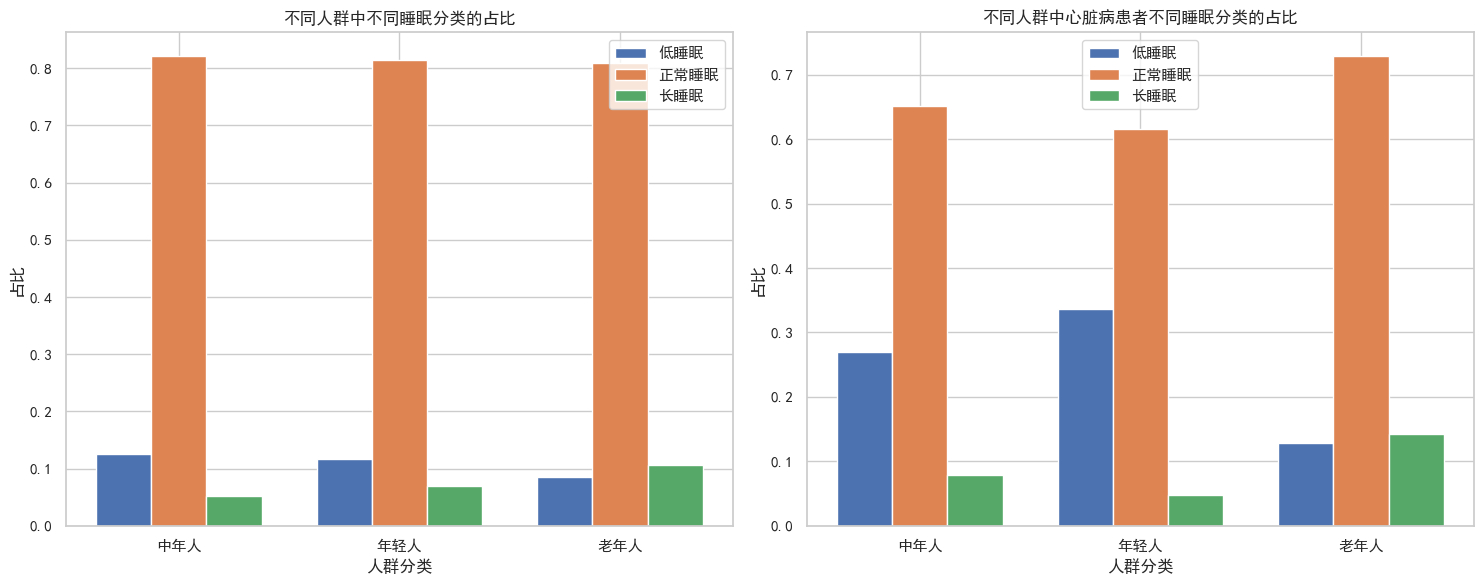

In [21]:
# 根据SleepHours进行睡眠分类
def get_sleep_category(sleep_hours):
    if sleep_hours < 6:
        return '低睡眠'
    elif 6 <= sleep_hours < 9:
        return '正常睡眠'
    else:
        return '长睡眠'

df['睡眠分类'] = df['SleepHours'].apply(get_sleep_category)

# 计算不同人群中不同睡眠分类的占比
total_distribution = df.groupby('人群分类')['睡眠分类'].value_counts(normalize=True).rename('占比').reset_index()

# 筛选出心脏病患者
heart_attack_df = df[df['HadHeartAttack'] == 'Yes']

# 计算不同人群中心脏病患者不同睡眠分类的占比
heart_attack_distribution = heart_attack_df.groupby('人群分类')['睡眠分类'].value_counts(normalize=True).rename('占比').reset_index()

print('不同人群中不同睡眠分类的占比：')
print(total_distribution)
print('不同人群中HadHeartAttack为Yes的人群中不同睡眠分类的占比：')
print(heart_attack_distribution)

# 定义画图函数
def plot_distribution(data, title, ax):
    pivot_data = data.pivot(index='人群分类', columns='睡眠分类', values='占比')
    num_categories = len(pivot_data.index)
    num_sleep_categories = len(pivot_data.columns)
    bar_width = 1 / (num_sleep_categories + 1)
    index = np.arange(num_categories)

    for i, sleep_category in enumerate(pivot_data.columns):
        ax.bar(index + i * bar_width, pivot_data[sleep_category], width=bar_width, label=sleep_category)

    ax.set_title(title)
    ax.set_xlabel('人群分类')
    ax.set_ylabel('占比')
    ax.set_xticks(index + bar_width * (num_sleep_categories - 1) / 2)
    ax.set_xticklabels(pivot_data.index)
    ax.legend()

# 创建子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 绘制不同人群中不同睡眠分类的占比
plot_distribution(total_distribution, '不同人群中不同睡眠分类的占比', ax1)

# 绘制不同人群中 心脏病患者不同睡眠分类的占比
plot_distribution(heart_attack_distribution, '不同人群中心脏病患者不同睡眠分类的占比', ax2)

plt.tight_layout()
plt.show()

In [22]:
# 筛选出心脏病患者
heart_attack_patients = df[df['HadHeartAttack'] == 'Yes']

# 异常值处理函数
def remove_outliers(group):
    Q1 = group['BMI'].quantile(0.25)
    Q3 = group['BMI'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['BMI'] >= lower_bound) & (group['BMI'] <= upper_bound)]

# 对每个年龄组分别进行异常值处理
cleaned_data = pd.DataFrame()
for age_group in ['年轻人', '中年人', '老年人']:
    group_data = heart_attack_patients[heart_attack_patients['人群分类'] == age_group]
    cleaned_group = remove_outliers(group_data)
    cleaned_data = pd.concat([cleaned_data, cleaned_group])

# 创建箱线图
fig = go.Figure()

# 为每个年龄组添加箱线图
for age_group in ['年轻人', '中年人', '老年人']:
    data = cleaned_data[cleaned_data['人群分类'] == age_group]['BMI']
    
    fig.add_trace(go.Box(
        y=data,
        name=age_group,
        boxpoints='all',  # 显示所有点
        jitter=0.3,  # 添加抖动以避免点重叠
        pointpos=-1.8,  # 调整点的位置
        marker=dict(
            size=4,
            opacity=0.5
        ),
        boxmean=True  # 显示均值
    ))

# 更新布局
fig.update_layout(
    title={
        'text': '不同群体心脏病患者的BMI分布（已处理异常值）',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20)
    },
    yaxis_title='BMI',
    xaxis_title='人群分类',
    template='plotly_white',
    height=800,
    width=1000,
    showlegend=False,
    font=dict(size=14)
)

# 添加BMI分类的参考线
bmi_categories = {
    '偏瘦': 18.5,
    '正常': 24.9,
    '超重': 29.9,
    '肥胖': 40
}

for category, value in bmi_categories.items():
    fig.add_shape(
        type='line',
        y0=value,
        y1=value,
        x0=-0.5,
        x1=2.5,
        line=dict(
            color='gray',
            width=1,
            dash='dash'
        )
    )
    fig.add_annotation(
        x=2.5,
        y=value,
        text=f'{category} ({value})',
        showarrow=False,
        xanchor='left',
        yanchor='bottom',
        font=dict(size=10)
    )

# 保存图表
fig.show()

In [23]:
# 定义要分析的疾病列表
diseases = ['HadAngina', 'HadStroke','HadAsthma','HadDiabetes']

# 计算Odds Ratio的函数（调整暴露组为目标疾病）
def calculate_odds_ratio(data, disease):
    # 创建2x2列联表（行：目标疾病，列：心脏病）
    table = pd.crosstab(data[disease], data['HadHeartAttack'])
    # 重新索引确保行和列顺序为Yes/No
    table = table.reindex(index=['Yes', 'No'], columns=['Yes', 'No'], fill_value=0)
    
    # 确保表格是2x2的
    if table.shape != (2, 2):
        return np.nan
    
    # 调整变量定义（暴露组为目标疾病）
    a = table.loc['Yes', 'Yes']  # 患目标疾病且患心脏病
    b = table.loc['Yes', 'No']   # 患目标疾病但未患心脏病
    c = table.loc['No', 'Yes']   # 未患目标疾病但患心脏病
    d = table.loc['No', 'No']    # 未患目标疾病且未患心脏病
   
    # 避免除以零
    if b == 0 or c == 0:
        return np.nan
    
    odds_ratio = (a * d) / (b * c)  # 调整后的OR计算公式
    return odds_ratio

# 为每个年龄组计算Odds Ratio
results = []
for age_group in ['年轻人', '中年人', '老年人']:
    group_data = df[df['人群分类'] == age_group]  # 假设df是已定义的数据集
    for disease in diseases:
        odds_ratio = calculate_odds_ratio(group_data, disease)
        results.append({
            '年龄组': age_group,
            '疾病': disease,
            'Odds Ratio': odds_ratio
        })

# 转换为DataFrame
results_df = pd.DataFrame(results)

# 创建热力图（与原逻辑一致）
fig = go.Figure()

# 准备数据 
age_groups = results_df['年龄组'].cat.categories if hasattr(results_df['年龄组'], 'cat') else sorted(results_df['年龄组'].unique())
diseases = results_df['疾病'].cat.categories if hasattr(results_df['疾病'], 'cat') else sorted(results_df['疾病'].unique())
pivot_df = results_df.pivot_table(index='年龄组', columns='疾病', values='Odds Ratio', aggfunc='mean')
pivot_df = pivot_df.reindex(index=age_groups, columns=diseases)
z_data = pivot_df.values

# 创建热力图
fig.add_trace(go.Heatmap(
    z=z_data,
    x=diseases,
    y=age_groups,
    colorscale='RdBu',
    zmid=1,  # 设置中间值为1（OR=1表示无关联）
    text=[[f'{val:.2f}' for val in row] for row in z_data],
    texttemplate='%{text}',
    textfont={"size": 14},
    colorbar=dict(
        title='Odds Ratio',
        titleside='right'
    )
))

# 更新布局
fig.update_layout(
    title={
        'text': '不同年龄群体特定疾病与心脏病的关联性（Odds Ratio）',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20)
    },
    xaxis_title='疾病',
    yaxis_title='年龄组',
    template='plotly_white',
    height=600,
    width=1000,
    font=dict(size=14)
)

# 显示图表
fig.show()
    

# part3 心脏病致病因素的交互作用分析

In [25]:
data=df.copy()

# 1.关联规则挖掘潜在交互组合

In [27]:
disease_col=[
    'Sex',
    'AgeCategory',
    'HadHeartAttack',
    'HadAngina',
    'HadStroke',
    'HadAsthma',
    'HadSkinCancer',
    'HadCOPD',
    'HadDepressiveDisorder',
    'HadKidneyDisease',
    'HadArthritis',
    'HadDiabetes',
    'DeafOrHardOfHearing',
    'BlindOrVisionDifficulty',
    'DifficultyConcentrating',
    'DifficultyWalking',
    'DifficultyDressingBathing',
    'DifficultyErrands',
    'SmokerStatus',
    'ECigaretteUsage',
    'AlcoholDrinkers',
    'BMI']
heart_patients=data.copy()
heart_patients=heart_patients[disease_col]
#性别
heart_patients=heart_patients.replace({'Male':'Yes','Female':'No'})
#年龄
heart_patients['AgeCategory']=heart_patients['AgeCategory'].map( {
    'Age 18 to 24': 21, 'Age 25 to 29': 27, 'Age 30 to 34': 32, 'Age 35 to 39': 37,
    'Age 40 to 44': 42, 'Age 45 to 49': 47, 'Age 50 to 54': 52, 'Age 55 to 59': 57,
    'Age 60 to 64': 62, 'Age 65 to 69': 67, 'Age 70 to 74': 72, 'Age 75 to 79': 77, 'Age 80 or older': 90})
#调成2元特征
heart_patients=heart_patients.replace({'No, pre-diabetes or borderline diabetes':'Yes','Yes, but only during pregnancy (female)':'No'})
heart_patients=heart_patients.replace({'Current smoker - now smokes every day':'Yes','Current smoker - now smokes some days':'Yes','Former smoker':'Yes','Never smoked':'No'})
heart_patients=heart_patients.replace({'Never used e-cigarettes in my entire life':'No','Not at all (right now)':'No','Use them some days':'Yes','Use them every day':'Yes'})
heart_patients['Obesity'] = heart_patients['BMI'].apply(lambda x: 'Yes' if x >= 27 else 'No')
heart_patients.drop('BMI', axis=1, inplace=True)
# 分离病例组和对照组
cases = heart_patients[heart_patients.HadHeartAttack == 'Yes']
controls = heart_patients[heart_patients.HadHeartAttack == 'No']
# 年龄匹配（1:5病例对照比）
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=5).fit(controls[['AgeCategory']])
_, indices = nbrs.kneighbors(cases[['AgeCategory']])
# 构建平衡数据集
matched_controls = controls.iloc[indices.flatten()]
balanced_data = pd.concat([cases, matched_controls])

关联规则提取的重要参数：最小支持度0.03，最小置信度30%

In [29]:
#True:70岁以上男性,False70以下女性
balanced_data['AgeGroup']=balanced_data['AgeCategory'].apply(lambda x: 'Yes' if x>=60 else 'No')
# 转换目标变量
bool_columns = [col for col in balanced_data.columns if col != 'AgeCategory']
balanced_data[bool_columns] = balanced_data[bool_columns].apply(lambda x:x.map({'Yes': True,'No': False})) 
# 生成频繁项集（动态支持度阈值）
n_cases = len(cases)
support_threshold = 100 / n_cases  # 每个组合至少出现100次病例
frequent_itemsets = apriori(balanced_data.drop('AgeCategory', axis=1), min_support=max(0.03, support_threshold),use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
#转换冻结集合为可读字符串
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))
# 筛选关键指标
report_cols = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
meaningful_rules = rules[rules['consequents'] == 'HadHeartAttack'][report_cols]
# 按提升度排序
meaningful_rules = meaningful_rules.sort_values('lift', ascending=False)
print(meaningful_rules.head(10))

                                 antecedents     consequents   support  \
1864            Sex, SmokerStatus, HadAngina  HadHeartAttack  0.036596   
9101  AgeGroup, Sex, SmokerStatus, HadAngina  HadHeartAttack  0.030964   
4194       AgeGroup, HadAngina, SmokerStatus  HadHeartAttack  0.042786   
556                   HadAngina, HadDiabetes  HadHeartAttack  0.035653   
4185        Obesity, SmokerStatus, HadAngina  HadHeartAttack  0.032949   
562                  SmokerStatus, HadAngina  HadHeartAttack  0.051569   
4157   SmokerStatus, HadAngina, HadArthritis  HadHeartAttack  0.032676   
567               HadAngina, AlcoholDrinkers  HadHeartAttack  0.032502   
575                      AgeGroup, HadAngina  HadHeartAttack  0.070153   
24                                 HadAngina  HadHeartAttack  0.084009   

      confidence      lift  
1864    1.000000  6.000000  
9101    1.000000  6.000000  
4194    1.000000  6.000000  
556     1.000000  6.000000  
4185    1.000000  6.000000  
562     0.7

**初步提取出的关联规则项：心绞痛+抽烟（男性+高龄+无年龄和性别的限定），心绞痛+糖尿病，心绞痛+饮酒，心绞痛+运动障碍，心绞痛+肥胖（男性）**

In [31]:
# 2.通过逻辑回归检验交互作用的显著性

In [32]:
df1=data.copy()
df1=df1[disease_col]
col_bi=['HadHeartAttack', 'HadAngina', 'HadStroke',
       'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder',
       'HadKidneyDisease', 'HadArthritis', 
       'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'AlcoholDrinkers']
age_mapping={'Age 18 to 24': 21, 'Age 25 to 29': 27, 'Age 30 to 34': 32, 'Age 35 to 39': 37,
    'Age 40 to 44': 42, 'Age 45 to 49': 47, 'Age 50 to 54': 52, 'Age 55 to 59': 57,
    'Age 60 to 64': 62, 'Age 65 to 69': 67, 'Age 70 to 74': 72, 'Age 75 to 79': 77, 'Age 80 or older': 90}
#调成2元特征
def preprocess_data(df):
    # 复制原始数据
    df_clean = df.copy()  
    # 二分类变量 
    for col in col_bi:
        df_clean[col] = df_clean[col].map({'Yes':1,'No':0})
    # 特殊变量处理
    df_clean['HadDiabetes']=df_clean['HadDiabetes'].map({'No, pre-diabetes or borderline diabetes':1,'Yes, but only during pregnancy (female)':0,'Yes':1,'No':0})
    df_clean['Sex'] = df_clean['Sex'].map({'Male': 1, 'Female': 0})
    df_clean['AgeCategory'] = df_clean['AgeCategory'].map(age_mapping) 
    # 年龄BMI标准化
    scaler=StandardScaler()
    df_clean['AgeCategory']=scaler.fit_transform(df_clean[['AgeCategory']])
    df_clean['BMI']=scaler.fit_transform(df_clean[['BMI']])
    # 有序分类变量
    df_clean['SmokerStatus'] = df_clean['SmokerStatus'].map({
        'Never smoked': 0,
        'Former smoker': 1,
        'Current smoker - now smokes some days': 2,
        'Current smoker - now smokes every day': 3
    })
    df_clean['ECigaretteUsage']=df_clean['ECigaretteUsage'].map({'Never used e-cigarettes in my entire life':0,'Not at all (right now)':0,'Use them some days':1,'Use them every day':2})
    return df_clean
# 执行预处理
df_processed = preprocess_data(df1)

In [33]:
#获取主效应
X_multi=['BMI','HadAngina','HadDiabetes','Sex','AgeCategory','AlcoholDrinkers','DifficultyWalking','SmokerStatus']
X_main=df_processed[X_multi]
X_main=sm.add_constant(X_main)
y=df_processed['HadHeartAttack']
sample_weight = np.where(y == 1, 20, 1)
model_main = sm.Logit(y, X_main)
result_main= model_main.fit_regularized(method='l1', alpha=0, weights=sample_weight,disp=0)
# 提取主效应结果
main_effects = pd.DataFrame({
    'Variable': result_main.params.index,
    'Coef': result_main.params.round(3),
    'OR': np.exp(result_main.params).round(3),
    'P_value': result_main.pvalues.round(4),
    'CI_lower': np.exp(result_main.conf_int()[0]).round(3),
    'CI_upper': np.exp(result_main.conf_int()[1]).round(3)
})
# 筛选主效应行（排除截距）
main_effects = main_effects[main_effects['Variable'] != 'const']
print("主效应分析结果：")
print(main_effects.to_markdown(index=False))

主效应分析结果：
| Variable          |   Coef |     OR |   P_value |   CI_lower |   CI_upper |
|:------------------|-------:|-------:|----------:|-----------:|-----------:|
| BMI               |  0.035 |  1.035 |    0.0012 |      1.014 |      1.057 |
| HadAngina         |  2.7   | 14.878 |    0      |     14.249 |     15.534 |
| HadDiabetes       |  0.494 |  1.639 |    0      |      1.566 |      1.714 |
| Sex               |  0.651 |  1.917 |    0      |      1.838 |      1.998 |
| AgeCategory       |  0.592 |  1.807 |    0      |      1.762 |      1.854 |
| AlcoholDrinkers   | -0.337 |  0.714 |    0      |      0.685 |      0.744 |
| DifficultyWalking |  0.546 |  1.727 |    0      |      1.649 |      1.809 |
| SmokerStatus      |  0.298 |  1.347 |    0      |      1.319 |      1.374 |


In [34]:
interaction_pairs = [
    ('BMI','Sex'),
    ('BMI','AgeCategory'),
    ('HadAngina','BMI'),
    ('HadAngina', 'HadDiabetes'),      # 规则491
    ('HadAngina', 'SmokerStatus'),     # 规则497
    ('Sex', 'HadAngina'),              # 规则172
    ('AgeCategory', 'HadAngina'),      # 规则1704
    ('HadAngina', 'DifficultyWalking'),
     ('HadAngina','AlcoholDrinkers')]
for var1, var2 in interaction_pairs:
    df_processed[f'{var1}_x_{var2}'] = df_processed[var1] * df_processed[var2]
#逻辑回归建模（带交互项）
def run_logistic_regression(df, target_var, main_effects, interaction_term):
    """运行带交互项的逻辑回归"""
    # 准备变量
    X = df[[main_effects[0], main_effects[1], interaction_term]]
    X = sm.add_constant(X)  # 添加截距项
    y = df[target_var]
    #加权
    sample_weight = np.where(y == 1, 20, 1)
    # 拟合模型
    model = sm.Logit(y, X)
    result = model.fit_regularized(method='l1', alpha=0, weights=sample_weight,disp=0)
    # 计算OR值和置信区间
    odds_ratios = np.exp(result.params)
    conf_int = np.exp(result.conf_int())
    conf_int.columns = ['OR_2.5%', 'OR_97.5%']
    # 合并结果
    results_df = pd.DataFrame({
        'Variable': result.params.index,
        'Coef': result.params.round(3),
        'P-value': result.pvalues.round(4),
        'OR': odds_ratios.round(3),
        'CI_lower': conf_int['OR_2.5%'].round(3),
        'CI_upper': conf_int['OR_97.5%'].round(3)})
    return results_df
#批量运行所有交互项分析
all_results = []
for var1, var2 in interaction_pairs:
    res = run_logistic_regression(
        df_processed, 
        target_var='HadHeartAttack',
        main_effects=[var1, var2],
        interaction_term=f'{var1}_x_{var2}'
    )
    res['Interaction'] = f"{var1} × {var2}"
    all_results.append(res)
# 合并所有结果
final_results = pd.concat(all_results)
final_results = final_results[['Interaction', 'Variable', 'Coef', 'P-value', 'OR', 'CI_lower', 'CI_upper']]
# 6. 结果筛选与展示
significant_interactions = final_results[
    (final_results['Variable'].str.contains('_x_')) & 
    (final_results['P-value'] < 0.05)]
print("="*50)
print("显著交互作用结果：")
print(significant_interactions.to_markdown(index=False))
print("="*50)

显著交互作用结果：
| Interaction                   | Variable                      |   Coef |   P-value |    OR |   CI_lower |   CI_upper |
|:------------------------------|:------------------------------|-------:|----------:|------:|-----------:|-----------:|
| BMI × AgeCategory             | BMI_x_AgeCategory             |  0.047 |    0      | 1.048 |      1.027 |      1.07  |
| HadAngina × BMI               | HadAngina_x_BMI               | -0.149 |    0      | 0.861 |      0.829 |      0.895 |
| HadAngina × HadDiabetes       | HadAngina_x_HadDiabetes       | -0.726 |    0      | 0.484 |      0.444 |      0.526 |
| HadAngina × SmokerStatus      | HadAngina_x_SmokerStatus      | -0.063 |    0.0034 | 0.939 |      0.901 |      0.98  |
| AgeCategory × HadAngina       | AgeCategory_x_HadAngina       | -0.777 |    0      | 0.46  |      0.436 |      0.485 |
| HadAngina × DifficultyWalking | HadAngina_x_DifficultyWalking | -1.065 |    0      | 0.345 |      0.317 |      0.375 |
| HadAngina × AlcoholD

In [35]:
#三阶作用
df_processed['triple_interaction'] = df_processed['HadAngina'] * df_processed['BMI'] * df_processed['Sex']
model = sm.Logit(
    df_processed['HadHeartAttack'],
    sm.add_constant(df_processed[['HadAngina', 'BMI', 'Sex', 
                       'HadAngina_x_BMI', 'triple_interaction']])
)
print(model.fit(weights=sample_weight).summary())

Optimization terminated successfully.
         Current function value: 0.163141
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:         HadHeartAttack   No. Observations:               246013
Model:                          Logit   Df Residuals:                   246007
Method:                           MLE   Df Model:                            5
Date:                Fri, 06 Jun 2025   Pseudo R-squ.:                  0.2300
Time:                        20:59:57   Log-Likelihood:                -40135.
converged:                       True   LL-Null:                       -52124.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.7845      0.017   -218.317      0.000      -3.818      -3.750
HadAn

**结果：心绞痛+糖尿病/心绞痛+吸烟/年龄+心绞痛/心绞痛+行动困难——OR值显示负交互作用，结合主效应的OR值发现，除了饮酒+心绞痛，其他交互项目共存会使得实际风险降低，而饮酒本身是负相关但是饮酒+心绞痛是正相关**

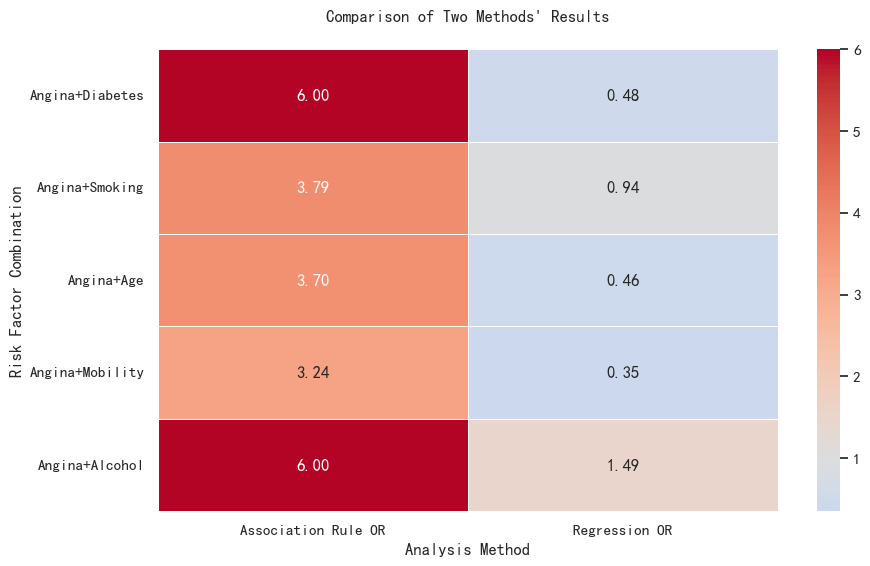

In [37]:
import matplotlib.pyplot as plt
# 交互效应热力图
effects = pd.DataFrame({
    'Combination': ['Angina+Diabetes', 'Angina+Smoking', 'Angina+Age', 'Angina+Mobility','Angina+Alcohol'],
    'Association Rule OR': [6.0, 3.79, 3.70, 3.24,6.0],  # Lift值近似OR
    'Regression OR': [0.48, 0.94, 0.46, 0.35,1.49]
}).set_index('Combination')

plt.figure(figsize=(10,6))
plt.title("Comparison of Two Methods' Results", pad=20)
sns.heatmap(effects, annot=True, fmt=".2f", cmap="coolwarm", 
            center=1, linewidths=0.5)
plt.xlabel("Analysis Method")
plt.ylabel("Risk Factor Combination")
plt.show()

# 3.亚人群分类

In [39]:
df2=df1.copy()
def preprocess1_data(df):
    # 复制原始数据
    df_clean = df.copy()  
    # 二分类变量 
    for col in col_bi:
        df_clean[col] = df_clean[col].map({'Yes':1,'No':0})
    # 特殊变量处理
    df_clean['HadDiabetes']=df_clean['HadDiabetes'].map({'No, pre-diabetes or borderline diabetes':1,'Yes, but only during pregnancy (female)':0,'Yes':1,'No':0})
    df_clean['Sex'] = df_clean['Sex'].map({'Male': 1, 'Female': 0})
    df_clean['AgeCategory'] = df_clean['AgeCategory'].map(age_mapping) 
    # 年龄BMI标准化
    scaler=StandardScaler()
    #df_clean['AgeCategory']=scaler.fit_transform(df_clean[['AgeCategory']])
    df_clean['BMI']=scaler.fit_transform(df_clean[['BMI']])
    # 有序分类变量
    df_clean['SmokerStatus'] = df_clean['SmokerStatus'].map({
        'Never smoked': 0,
        'Former smoker': 1,
        'Current smoker - now smokes some days': 2,
        'Current smoker - now smokes every day': 3
    })
    df_clean['ECigaretteUsage']=df_clean['ECigaretteUsage'].map({'Never used e-cigarettes in my entire life':0,'Not at all (right now)':0,'Use them some days':1,'Use them every day':2})
    return df_clean
# 执行预处理
df_processeds_sub = preprocess1_data(df2)

In [40]:
#Age*Sex
# 确保所有交互项已创建
interaction_terms = [
    'HadAngina_x_AlcoholDrinkers',
    'HadAngina_x_SmokerStatus',
    'HadAngina_x_HadDiabetes']
# 合并主效应和交互项
X_multi_extended = [
    'HadAngina', 'HadDiabetes', 'Sex', 'AgeCategory', 
    'AlcoholDrinkers', 'DifficultyWalking', 'SmokerStatus'
] + interaction_terms
# 先创建年龄分组
df_processeds_sub['AgeGroup'] = pd.cut(df_processeds_sub['AgeCategory'], 
                                 bins=[0, 50, 65, 90],
                                 labels=['<50', '50-65', '>65'])
df_processeds_sub['HadAngina_x_AlcoholDrinkers'] = df_processeds_sub['HadAngina'] * df_processeds_sub['AlcoholDrinkers']
df_processeds_sub['HadAngina_x_SmokerStatus'] = df_processeds_sub['HadAngina'] * df_processeds_sub['SmokerStatus']
df_processeds_sub['HadAngina_x_HadDiabetes'] = df_processeds_sub['HadAngina'] * df_processeds_sub['HadDiabetes']
# 亚群分析函数
def subgroup_interaction_analysis(df, group_vars=['AgeGroup', 'Sex'], min_samples=100):
    """
    多交互项亚群分析
    :param df: 包含所有变量的DataFrame
    :param group_vars: 分组变量列表
    :param min_samples: 最小样本量要求
    :return: 结果DataFrame
    """
    results = []
    groups = df.groupby(group_vars,observed=False)
    for name, subset in groups:
        if len(subset) >= min_samples:
            # 检查变量是否有足够变异
            var_check = all([
                subset['HadAngina'].nunique() > 1,
                subset['AlcoholDrinkers'].nunique() > 1,
                subset['SmokerStatus'].nunique() > 1,
                subset['HadDiabetes'].nunique() > 1
            ])
            if var_check:
                try:
                    X = sm.add_constant(subset[X_multi_extended])
                    y = subset['HadHeartAttack']
                    case_control_ratio = len(y[y==0]) / len(y[y==1])  # 对照组/病例组比例
                    weights = np.where(y == 1, case_control_ratio, 1)
                    # 使用更稳健的拟合方法
                    model = sm.Logit(y, X).fit(
                        disp=0,
                        method='bfgs',
                        maxiter=100,
                        weights=weights)
                    # 提取所有交互项结果
                    res = {
                        'Subgroup': ' | '.join([f"{var}={val}" for var, val in zip(group_vars, name)]),
                        'N': len(subset),
                        'Angina_OR': np.exp(model.params['HadAngina']).round(2)
                    }
                    for term in interaction_terms:
                        if term in model.params:
                            res.update({
                                f"{term}_OR": np.exp(model.params[term]).round(2),
                                f"{term}_P": model.pvalues[term].round(4)
                            })
                        else:
                            res.update({
                                f"{term}_OR": np.nan,
                                f"{term}_P": np.nan
                            })
                    
                    results.append(res)
                    
                except Exception as e:
                    print(f"警告：分组 {name} 拟合失败 - {str(e)}")
            else:
                print(f"跳过 {name}：关键变量缺乏变异")
        else:
            print(f"跳过 {name}：样本量不足 (N={len(subset)})")
    
    return pd.DataFrame(results)

# 执行分析
results_df = subgroup_interaction_analysis(df_processeds_sub)
print("\n亚群分析结果：")
print(results_df.to_markdown(index=False))


亚群分析结果：
| Subgroup               |     N |   Angina_OR |   HadAngina_x_AlcoholDrinkers_OR |   HadAngina_x_AlcoholDrinkers_P |   HadAngina_x_SmokerStatus_OR |   HadAngina_x_SmokerStatus_P |   HadAngina_x_HadDiabetes_OR |   HadAngina_x_HadDiabetes_P |
|:-----------------------|------:|------------:|---------------------------------:|--------------------------------:|------------------------------:|-----------------------------:|-----------------------------:|----------------------------:|
| AgeGroup=<50 | Sex=0   | 42901 |       46.78 |                             1.22 |                        nan      |                          0.68 |                     nan      |                         0.48 |                    nan      |
| AgeGroup=<50 | Sex=1   | 44016 |       57.33 |                             1.03 |                          0.9059 |                          0.77 |                       0.0083 |                         0.44 |                      0.0013 |
| AgeGroup=50-65 | Sex=

65岁以下的女性黑塞矩阵计算失败（交互项的p值显示为nan或者-），即有可能亚群样本量过小或者变异不足

In [42]:
#Age*BMI
def enhanced_preprocessing(df):
    df_clean = df.copy()
    
    # 二分类变量处理（保持您的原始逻辑）
    for col in col_bi:
        df_clean[col] = df_clean[col].map({'Yes':1, 'No':0})
    
    # 特殊变量处理（优化糖尿病分类）
    df_clean['HadDiabetes'] = df_clean['HadDiabetes'].apply(
        lambda x: 1 if x in ['No, pre-diabetes or borderline diabetes', 'Yes'] else 0)
    # 有序分类变量
    df_clean['SmokerStatus'] = df_clean['SmokerStatus'].map({
        'Never smoked': 0,
        'Former smoker': 1,
        'Current smoker - now smokes some days': 2,
        'Current smoker - now smokes every day': 3
    })
    df_clean['ECigaretteUsage']=df_clean['ECigaretteUsage'].map({'Never used e-cigarettes in my entire life':0,'Not at all (right now)':0,'Use them some days':1,'Use them every day':2})
    # 性别和年龄处理
    df_clean['Sex'] = df_clean['Sex'].map({'Male': 1, 'Female': 0})
    df_clean['AgeCategory'] = df_clean['AgeCategory'].map(age_mapping)
    
    # BMI分类（新增）
    df_clean['BMI_Category'] = pd.cut(df_clean['BMI'],
                                     bins=[0, 18.5, 25, 30, 100],
                                     labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
    
    # 年龄分组（新增）
    df_clean['Age_Group'] = pd.cut(df_clean['AgeCategory'],
                                  bins=[0, 50, 65, 100],
                                  labels=['<50', '50-65', '>65'])
    # 标准化处理（保持您的原始逻辑）
    scaler = StandardScaler()
    df_clean['BMI_scaled'] = scaler.fit_transform(df_clean[['BMI']])
    
    return df_clean

# 执行增强版预处理
df_processed = enhanced_preprocessing(df2)

In [43]:
def subgroup_analysis(df, target='HadHeartAttack'):
    results = []
    
    # 定义亚群组合
    subgroups = [
        ('All', df),
        *[(f'Age_{age}', df[df['Age_Group'] == age]) for age in df['Age_Group'].unique()],
        *[(f'BMI_{bmi}', df[df['BMI_Category'] == bmi]) for bmi in df['BMI_Category'].unique()],
        *[(f'Age_{age}_BMI_{bmi}', 
           df[(df['Age_Group'] == age) & (df['BMI_Category'] == bmi)])
          for age in df['Age_Group'].unique() 
          for bmi in df['BMI_Category'].unique()]
    ]
    
    # 核心分析逻辑
    for name, sub_df in subgroups:
        if len(sub_df) < 100:  # 小样本跳过
            continue 
        # 计算基础统计量
        n = len(sub_df)
        event_rate = sub_df[target].mean()
        # 计算关键指标的OR值（简化版）
        def calculate_or(feature):
            table = pd.crosstab(sub_df[feature], sub_df[target])
            if table.shape != (2,2):
                return np.nan
            return (table.iloc[1,1]/table.iloc[1,0]) / (table.iloc[0,1]/table.iloc[0,0])
        
        or_values = {
            'HadAngina_OR': calculate_or('HadAngina'),
            'SmokerStatus_OR': calculate_or('SmokerStatus'),
            'AlcoholDrinkers_OR': calculate_or('AlcoholDrinkers')
        }
        
        # 计算交互作用OR（联合效应与独立效应的比值）
        def calculate_interaction_or(feature1, feature2):
            # 创建交互组：0=无风险因素，1=仅feature1，2=仅feature2，3=两者都有
            sub_df['interaction_group'] = sub_df[feature1].astype(int) + 2 * sub_df[feature2].astype(int)
            # 计算各组事件率
            group_rates = sub_df.groupby('interaction_group')[target].mean()
            if len(group_rates) < 4:
                return np.nan

            # 计算交互OR = (两者都有的事件率)/(单独feature1事件率 * 单独feature2事件率)
            return (group_rates[3] / group_rates[0]) / ((group_rates[1]/group_rates[0]) * (group_rates[2]/group_rates[0]))
        
        results.append({
            'Subgroup': name,
            'N': n,
            'Event_Rate': event_rate,
            'HadAngina_OR': calculate_or('HadAngina'),
            'AlcoholDrinkers_OR': calculate_or('AlcoholDrinkers'),
            'HadAngina_x_AlcoholDrinkers_OR': calculate_interaction_or('HadAngina', 'AlcoholDrinkers'),
            'HadAngina_x_SmokerStatus_OR': calculate_interaction_or('HadAngina', 'SmokerStatus')
        })
    
    return pd.DataFrame(results)

# 执行亚群分析
subgroup_results = subgroup_analysis(df_processed)
subgroup_results

Subgroup       N  Event_Rate  HadAngina_OR  \
0                         All  246013    0.054611     27.877755   
1                     Age_>65   90241    0.100331     14.804045   
2                   Age_50-65   68855    0.049234     34.100615   
3                     Age_<50   86917    0.011402     60.440240   
4              BMI_Overweight   87421    0.056623     27.444747   
5                   BMI_Obese   84123    0.063371     24.114840   
6                  BMI_Normal   70712    0.041761     34.429174   
7             BMI_Underweight    3757    0.053500     31.295502   
8      Age_>65_BMI_Overweight   34378    0.102537     14.314127   
9           Age_>65_BMI_Obese   27127    0.119549     12.788704   
10         Age_>65_BMI_Normal   27246    0.079241     17.676340   
11    Age_>65_BMI_Underweight    1490    0.085235     21.974631   
12   Age_50-65_BMI_Overweight   24646    0.046133     37.308333   
13        Age_50-65_BMI_Obese   27131    0.060226     26.638798   
14       Age_50-65_BMI_Normal   16311    0.034823     52.156146   
15  Age_50-65_BMI_Underweight     767    0.066493     27.144444   
16     Age_<50_BMI_Overweight   28397    0.010142     87.057908   
17          Age_<50_BMI_Obese   29865    0.015202     41.447497   
18         Age_<50_BMI_Normal   27155    0.008323     73.439815   
19    Age_<50_BMI_Underweight    1500    0.015333     37.020202   

    AlcoholDrinkers_OR  HadAngina_x_AlcoholDrinkers_OR  \
0             0.518501                        1.622146   
1             0.664768                        1.271237   
2             0.504949                        1.816191   
3             0.565155                        1.280130   
4             0.534622                        1.604387   
5             0.562798                        1.548041   
6             0.455329                        1.670934   
7             0.489336                        1.667336   
8             0.694951                        1.210641   
9             0.749607                        1.157447   
10            0.567545                        1.447904   
11            0.624646                        1.495197   
12            0.491111                        2.039931   
13            0.584989                        1.654040   
14            0.435316                        1.507567   
15            0.430335                        1.608586   
16            0.578168                        1.083937   
17            0.601370                        1.331180   
18            0.544715                        1.258162   
19            0.577580                        1.047165   

    HadAngina_x_SmokerStatus_OR  
0                      0.594405  
1                      0.778352  
2                      0.680327  
3                      0.598409  
4                      0.545945  
5                      0.733687  
6                      0.500548  
7                      0.389710  
8                      0.750899  
9                      0.920545  
10                     0.672671  
11                     0.355122  
12                     0.556848  
13                     0.795755  
14                     0.625836  
15                     7.187809  
16                     0.409276  
17                     0.826401  
18                     0.726954  
19                     0.000000

# Part 4  利用机器学习进行心脏病风险预测

## 1.数据预处理

In [3]:
df1 = df.copy()  # 为避免修改原始数据,创建副本
# 各个年龄段分别用中位数代替
encode_AgeCategory = {'Age 55 to 59':57, 'Age 80 or older':80, 'Age 65 to 69':67,
                      'Age 75 to 79':77,'Age 40 to 44':42,'Age 70 to 74':72,'Age 60 to 64':62,
                      'Age 50 to 54':52,'Age 45 to 49':47,'Age 18 to 24':21,'Age 35 to 39':37,
                      'Age 30 to 34':32,'Age 25 to 29':27}
df1['AgeCategory'] = df1['AgeCategory'].apply(lambda x: encode_AgeCategory[x]).astype('float')
# 是否接种破伤风、是否接种新冠疫苗、是否患有糖尿病唯一值合并为二分类
df1['TetanusLast10Tdap'] = df1['TetanusLast10Tdap'].replace(['Yes, received Tdap','Yes, received tetanus shot but not sure what type'
                                                                 ,'Yes, received tetanus shot, but not Tdap',
                                                                 'No, did not receive any tetanus shot in the past 10 years'],['Yes','Yes','Yes','No'])
df1['CovidPos'] = df1['CovidPos'].str.replace('Tested positive using home test without a health professional','Yes')
df1['HadDiabetes'] = df1['HadDiabetes'].str.replace('No, pre-diabetes or borderline diabetes','No').replace('Yes, but only during pregnancy (female)','Yes')
# 对多分类数据进行One Hot编码,并删除原始列
df1 = pd.get_dummies(df1, columns=['RaceEthnicityCategory', 'GeneralHealth', 'RemovedTeeth','SmokerStatus','ECigaretteUsage'],
                    prefix = ['RaceEthnicityCategory',  'GeneralHealth','RemovedTeeth', 'SmokerStatus','ECigaretteUsage'])
# 二分类数据进行标签编码
df1 =  df1[df1.columns].replace({'Yes':1, 'No':0, 'Male':1,'Female':0})
# State难以编码，上次检查时间和身高非心脏病的患病因素,故均删除
df1.drop(['State','LastCheckupTime','HeightInMeters'],axis = 1,inplace = True)
# 体重和BMI存在强正相关关系(相关系数=0.86),故删除体重
df1.drop(['WeightInKilograms'],axis = 1,inplace = True)

## 2.模型预测

选择六个模型,其中RF、ET、GBDT、Adaboost都是基于DT的集成学习模型

In [5]:
models = [
    ('Logistic Regression', 
     LogisticRegression(class_weight={0: 1, 1: 5}, random_state=42)),
    ('Decision Tree', 
     DecisionTreeClassifier(class_weight={0: 1, 1: 5}, random_state=42)), 
    ('Random Forest', 
     RandomForestClassifier(class_weight='balanced', random_state=42)),
    ('Extra Trees', 
     ExtraTreesClassifier(class_weight='balanced', random_state=42)),
    ('Gradient Boosting', 
     GradientBoostingClassifier(random_state=42)),  
    ('AdaBoost', 
     AdaBoostClassifier(random_state=42)),
]

对可视化的字体、字号进行自定义

In [7]:
# ========== 全局字体设置 ==========
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

# ========== 自定义样式参数 ==========
TITLE_FONT = {'fontsize': 20, 'fontweight': 'bold'}
AXIS_FONT = {'fontsize': 16, 'fontweight': 'normal'}
TICK_FONT = {'fontsize': 14}
LEGEND_FONT = {'size': 11}

定义训练+可视化展示函数，展示结果包括但不限于准确率、召回率、精确率、混淆矩阵、ROC曲线和PR曲线

In [9]:
def train_evaluate(models, X_train, X_test, y_train, y_test):
    # ========== 第一部分：混淆矩阵热力图 ==========
    n_models = len(models)
    n_cols = min(3, n_models)  # 每行最多3个子图
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes1 = axes1.flatten() if n_models > 1 else [axes1]
    
    # ========== 第二部分：全局ROC/PR曲线 ==========
    fig2, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(12, 5))
    ax_roc.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    ax_pr.axhline(y=sum(y_test)/len(y_test), color='k', linestyle='--', alpha=0.5, label='Random')
    
    for idx, (name, model) in enumerate(models):
        # --- 模型训练与评估 ---
        scores = cross_val_score(model, X_train, y_train, cv=5)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        # --- 计算指标 ---
        accuracy = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        ap_score = average_precision_score(y_test, y_proba)
        
        # --- 打印结果 ---
        print(f"\n{'='*40}\nModel: {name}\n{'='*40}")
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"AUC-ROC: {roc_auc:.4f} | Average Precision: {ap_score:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(cm)
        
        # --- 绘制混淆矩阵 ---
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Blues', ax=axes1[idx],
            cbar=False, annot_kws={'size': 20, 'fontweight': 'bold'}
        )
        axes1[idx].set_title(f'{name}\nAccuracy: {accuracy:.2f}', **TITLE_FONT)
        axes1[idx].set_xlabel('Predicted', **AXIS_FONT)
        axes1[idx].set_ylabel('Actual', **AXIS_FONT)
        axes1[idx].set_xticklabels(['Heart', 'No Heart'], **TICK_FONT)
        axes1[idx].set_yticklabels(['Heart', 'No Heart'], **TICK_FONT)
        
        # --- 绘制全局曲线 ---
        ax_roc.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.2f})', linewidth=2)
        ax_pr.plot(recall, precision, label=f'{name} (AP={ap_score:.2f})', linewidth=2)
    
    # --- 美化混淆矩阵图 ---
    for j in range(n_models, len(axes1)):
        axes1[j].axis('off')
    fig1.suptitle('Confusion Matrices Comparison', **TITLE_FONT, y=1.02)
    fig1.tight_layout()
    
    # --- 美化全局曲线图 ---
    ax_roc.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax_roc.set_xlabel('False Positive Rate', **AXIS_FONT)
    ax_roc.set_ylabel('True Positive Rate', **AXIS_FONT)
    ax_roc.set_title('ROC Curves', **TITLE_FONT)
    ax_roc.legend(loc='lower right', prop=LEGEND_FONT)
    ax_roc.grid(linestyle='--', alpha=0.3)
    
    ax_pr.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax_pr.set_xlabel('Recall', **AXIS_FONT)
    ax_pr.set_ylabel('Precision', **AXIS_FONT)
    ax_pr.set_title('Precision-Recall Curves', **TITLE_FONT)
    ax_pr.legend(loc='upper right', prop=LEGEND_FONT)
    ax_pr.grid(linestyle='--', alpha=0.3)
    
    fig2.tight_layout()
    plt.show()

提取特征矩阵和标签向量，并划分训练集和测试集合

In [11]:
from sklearn.metrics import confusion_matrix
# 特征选择：排除目标列和后加的非数值辅助列
X = df1.drop(columns=['HadHeartAttack', '人群分类', '睡眠分类'], errors='ignore')
y = df1['HadHeartAttack']

# 断言确认 X 中全是数值（否则模型报错）
assert X.select_dtypes(include='object').shape[1] == 0, "X 中仍有字符串列，请检查数据类型！"

# 数据拆分
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2.1 原始数据


Model: Logistic Regression
Test Accuracy: 0.9316
AUC-ROC: 0.8840 | Average Precision: 0.4022

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     46518
           1       0.40      0.54      0.46      2687

    accuracy                           0.93     49205
   macro avg       0.69      0.75      0.71     49205
weighted avg       0.94      0.93      0.94     49205

Confusion Matrix:
[[ 1439  1248]
 [ 2118 44400]]

Model: Decision Tree
Test Accuracy: 0.9166
AUC-ROC: 0.6098 | Average Precision: 0.1066

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     46518
           1       0.25      0.27      0.26      2687

    accuracy                           0.92     49205
   macro avg       0.60      0.61      0.61     49205
weighted avg       0.92      0.92      0.92     49205

Confusion Matrix:
[[  713  1974]
 [ 2131 44387]]

Model: Random For

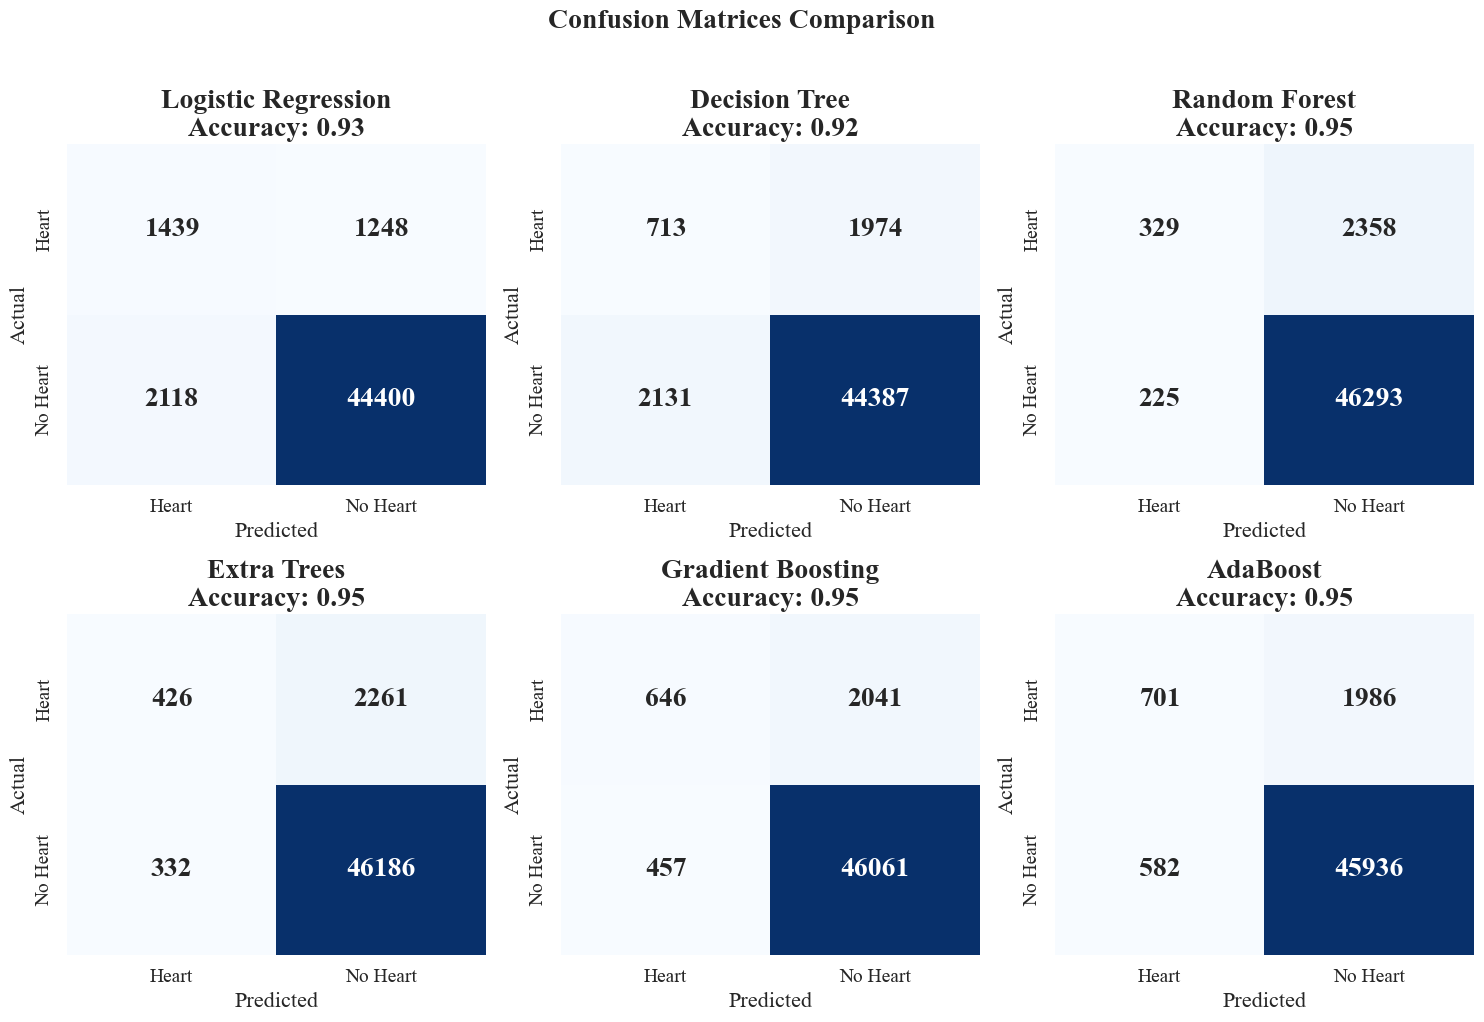

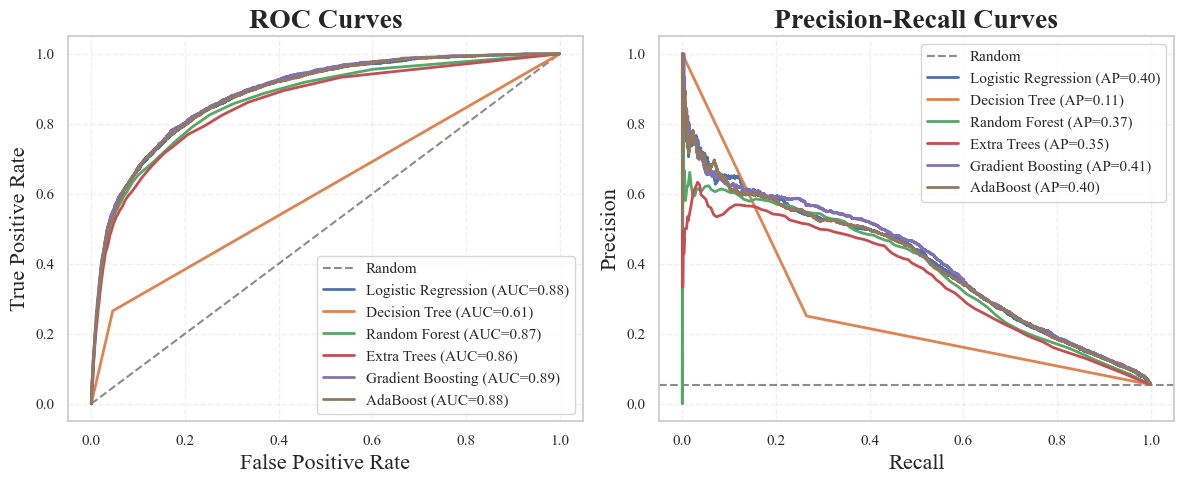

In [13]:

# 模型评估函数调用
train_evaluate(models, X_train, X_test, y_train, y_test)

### 2.2 随机欠采样

In [ ]:
sampler  = RandomUnderSampler(sampling_strategy='majority')
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)
train_evaluate(models,X_train_resampled, X_test, y_train_resampled, y_test)


Model: Logistic Regression
Test Accuracy: 0.5020
AUC-ROC: 0.8848 | Average Precision: 0.4005

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.48      0.64     46518
           1       0.10      0.96      0.17      2687

    accuracy                           0.50     49205
   macro avg       0.55      0.72      0.41     49205
weighted avg       0.95      0.50      0.62     49205

Confusion Matrix:
[[ 2579   108]
 [24397 22121]]

Model: Decision Tree
Test Accuracy: 0.7416
AUC-ROC: 0.7182 | Average Precision: 0.1104

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.74      0.84     46518
           1       0.14      0.69      0.23      2687

    accuracy                           0.74     49205
   macro avg       0.56      0.72      0.54     49205
weighted avg       0.93      0.74      0.81     49205

Confusion Matrix:
[[ 1859   828]
 [11886 34632]]

Model: Random For

### 2.3 EasyEnsemble算法

In [ ]:
重新定义训练+可视化函数

In [ ]:
def train_evaluate_with_easyensemble(models, X_train, X_test, y_train, y_test):
    # ========== 第一部分：混淆矩阵热力图 ==========
    n_models = len(models)
    n_cols = min(3, n_models)  # 每行最多3个子图
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes1 = axes1.flatten() if n_models > 1 else [axes1]
    
    # ========== 第二部分：全局ROC/PR曲线 ==========
    fig2, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(12, 5))
    ax_roc.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    random_precision = sum(y_test)/len(y_test)  # PR曲线随机基准
    ax_pr.axhline(y=random_precision, color='k', linestyle='--', alpha=0.5, label='Random')
    
    for idx, (name, model) in enumerate(models):
        # --- 使用EasyEnsemble包装模型 ---
        easy_ensemble = EasyEnsembleClassifier(
            estimator=model,
            n_estimators=20,
            random_state=42
        )
        
        # --- 模型训练与评估 ---
        easy_ensemble.fit(X_train, y_train)
        y_pred = easy_ensemble.predict(X_test)
        y_proba = easy_ensemble.predict_proba(X_test)[:, 1]
        
        # --- 计算指标 ---
        accuracy = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        ap_score = average_precision_score(y_test, y_proba)
        
        # --- 打印结果 ---
        print(f"\n{'='*40}\nModel: {name} with EasyEnsemble\n{'='*40}")
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"AUC-ROC: {roc_auc:.4f} | Average Precision: {ap_score:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(cm)
        
        # --- 绘制混淆矩阵 ---
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Blues', ax=axes1[idx],
            cbar=False, annot_kws={'size': 20, 'fontweight': 'bold'}
        )
        axes1[idx].set_title(f'{name}\nAccuracy: {accuracy:.2f}', **TITLE_FONT)
        axes1[idx].set_xlabel('Predicted', **AXIS_FONT)
        axes1[idx].set_ylabel('Actual', **AXIS_FONT)
        axes1[idx].set_xticklabels(['Heart', 'No Heart'], **TICK_FONT)
        axes1[idx].set_yticklabels(['Heart', 'No Heart'], **TICK_FONT)
        
        # --- 绘制全局曲线 ---
        ax_roc.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.2f})', linewidth=2)
        ax_pr.plot(recall, precision, label=f'{name} (AP={ap_score:.2f})', linewidth=2)
    
    # --- 美化混淆矩阵图 ---
    for j in range(n_models, len(axes1)):
        axes1[j].axis('off')
    fig1.suptitle('Confusion Matrices with EasyEnsemble', **TITLE_FONT, y=1.02)
    fig1.tight_layout()
    
    # --- 美化全局曲线图 ---
    ax_roc.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax_roc.set_xlabel('False Positive Rate', **AXIS_FONT)
    ax_roc.set_ylabel('True Positive Rate', **AXIS_FONT)
    ax_roc.set_title('ROC Curves Comparison', **TITLE_FONT)
    ax_roc.legend(loc='lower right', prop=LEGEND_FONT)
    ax_roc.grid(linestyle='--', alpha=0.3)
    
    ax_pr.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax_pr.set_xlabel('Recall', **AXIS_FONT)
    ax_pr.set_ylabel('Precision', **AXIS_FONT)
    ax_pr.set_title('PR Curves Comparison', **TITLE_FONT)
    ax_pr.legend(loc='upper right', prop=LEGEND_FONT)
    ax_pr.grid(linestyle='--', alpha=0.3)
    
    fig2.tight_layout()
    plt.show()

In [ ]:
train_evaluate_with_easyensemble(models, X_train, X_test, y_train, y_test)

### 2.4 随机过采样

In [ ]:
def train_evaluate_oversample(models, X_train, X_test, y_train, y_test):
    # ========== 第一部分：混淆矩阵热力图 ==========
    n_models = len(models)
    n_cols = min(3, n_models)
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes1 = axes1.flatten() if n_models > 1 else [axes1]
    
    # ========== 第二部分：ROC和PR曲线 ==========
    fig2, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(12, 5))
    ax_roc.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    ax_pr.axhline(y=sum(y_test)/len(y_test), color='k', linestyle='--', alpha=0.5, label='Random')
    
    # ========== 第三部分：特征重要性 ==========
    tree_models = ['Decision Tree Classifier', 'Random Forest', 'Extra Trees', 'Gradient Boosting', 'AdaBoost Classifier']
    tree_models_in_list = [name for name, _ in models if name in tree_models]
    
    if tree_models_in_list:
        fig3, axes3 = plt.subplots(len(tree_models_in_list), 1, figsize=(12, 2*len(tree_models_in_list)))
        if len(tree_models_in_list) == 1:
            axes3 = [axes3]
        
        # 创建彩虹色配色方案
        colors = plt.cm.rainbow(np.linspace(0, 1, 10))
        
        for idx, (name, model) in enumerate([m for m in models if m[0] in tree_models_in_list]):
            try:
                importances = model.feature_importances_
                indices = np.argsort(importances)[-10:]  # 取前10个重要特征
                sorted_idx = np.argsort(importances[indices])
                
                ax = axes3[tree_models_in_list.index(name)]
                bars = ax.barh(range(len(indices)), importances[indices][sorted_idx], color=colors, align='center')
                
                ax.set_title(f'{name} - Top 10 Features', **TITLE_FONT)
                ax.set_yticks(range(len(indices)))
                ax.set_yticklabels([X_train.columns[indices[i]] for i in sorted_idx], **{'fontsize':9, 'fontweight': 'normal'})
                ax.set_xlabel('Importance Score', **AXIS_FONT)
                ax.grid(axis='x', linestyle='--', alpha=0.3)
                
                # 添加数值标签
                for bar in bars:
                    width = bar.get_width()
                    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                            f'{width:.3f}', ha='left', va='center', **TICK_FONT)
                
            except AttributeError:
                pass
        
        fig3.tight_layout()

    # ========== 第四部分：指标比较 ==========
    metrics = {
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1-Score': [],
        'AUC-ROC': [],
        'AP': []
    }
    model_names = []
    
    for idx, (name, model) in enumerate(models):
        # --- 模型训练与评估 ---
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else [0]*len(y_test)
        
        # 计算各项指标
        metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['Precision'].append(precision_score(y_test, y_pred))
        metrics['Recall'].append(recall_score(y_test, y_pred))
        metrics['F1-Score'].append(f1_score(y_test, y_pred))


        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
        
        if hasattr(model, 'predict_proba'):
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
            ap_score = average_precision_score(y_test, y_proba)
        else:
            roc_auc = 0.5
            ap_score = sum(y_test)/len(y_test)

        metrics['Accuracy'].append(accuracy)
        metrics['Precision'].append(precision)
        metrics['Recall'].append(recall)
        metrics['F1-Score'].append(f1)
        metrics['AUC-ROC'].append(roc_auc)
        metrics['AP'].append(ap_score)
        model_names.append(name)
        
        print(f"\n{'='*40}\nModel: {name}\n{'='*40}")
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"AUC-ROC: {roc_auc:.4f} | Average Precision: {ap_score:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(cm)
        

        if hasattr(model, 'predict_proba'):
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            metrics['AUC-ROC'].append(auc(fpr, tpr))
            metrics['AP'].append(average_precision_score(y_test, y_proba))
        else:
            metrics['AUC-ROC'].append(0.5)
            metrics['AP'].append(sum(y_test)/len(y_test))
        
        model_names.append(name)
        
        # --- 绘制混淆矩阵 ---
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Blues', ax=axes1[idx],
            cbar=False, annot_kws={'size': 20, 'fontweight': 'bold'}
        )
        axes1[idx].set_title(f'{name}\nAccuracy: {metrics["Accuracy"][-1]:.2f}', **TITLE_FONT)
        axes1[idx].set_xlabel('Predicted', **AXIS_FONT)
        axes1[idx].set_ylabel('Actual', **AXIS_FONT)
        axes1[idx].set_xticklabels(['Heart', 'No Heart'], **TICK_FONT)
        axes1[idx].set_yticklabels(['Heart', 'No Heart'], **TICK_FONT)
        # --- 绘制ROC和PR曲线 ---
        if hasattr(model, 'predict_proba'):
            ax_roc.plot(fpr, tpr, label=f'{name} (AUC={metrics["AUC-ROC"][-1]:.2f})', linewidth=2)
            precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
            ax_pr.plot(recall_curve, precision_curve, label=f'{name} (AP={metrics["AP"][-1]:.2f})', linewidth=2)
    # 隐藏多余的子图
    for j in range(n_models, len(axes1)):
        axes1[j].axis('off')
    fig1.suptitle('Confusion Matrices Comparison', **TITLE_FONT, y=1.02)
    fig1.tight_layout()
    
    # 设置ROC和PR曲线图的样式
    ax_roc.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax_roc.set_xlabel('False Positive Rate', **AXIS_FONT)
    ax_roc.set_ylabel('True Positive Rate', **AXIS_FONT)
    ax_roc.set_title('ROC Curves', **TITLE_FONT)
    ax_roc.legend(loc='lower right', prop=LEGEND_FONT)
    ax_roc.grid(axis='both', linestyle='--', alpha=0.3)
    
    ax_pr.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax_pr.set_xlabel('Recall', **AXIS_FONT)
    ax_pr.set_ylabel('Precision', **AXIS_FONT)
    ax_pr.set_title('Precision-Recall Curves', **TITLE_FONT)
    ax_pr.legend(loc='upper right', prop=LEGEND_FONT)
    ax_pr.grid(axis='both', linestyle='--', alpha=0.3)
    fig2.tight_layout()

    # ========== 使用Plotly创建交互式指标比较图 ==========
    fig = go.Figure()
    
    # 定义颜色和标记样式
    colors = px.colors.qualitative.Plotly
    markers = ['circle', 'square', 'diamond', 'cross', 'x', 'triangle-up']
    
    # 为每个指标添加轨迹
    for i, (metric_name, values) in enumerate(metrics.items()):
        fig.add_trace(go.Scatter(
            x=model_names,
            y=values,
            name=metric_name,
            mode='lines+markers',
            marker=dict(
                symbol=markers[i % len(markers)],
                size=10,
                color=colors[i % len(colors)]
            ),
            line=dict(width=2, color=colors[i % len(colors)]),
            hovertemplate=
            "<b>%{x}</b><br>" +
            f"{metric_name}: " + "%{y:.3f}<br>" +
            "<extra></extra>",
        ))
    # 更新图表布局
    fig.update_layout(
        title={
            'text': 'Interactive Model Performance Comparison',
            'font': {'size': 18,'family': 'Times New Roman'} 
        },
        xaxis_title={
            'text': 'Models',
            'font': {'size': 14,'family': 'Times New Roman'}
        },
        yaxis_title={
            'text': 'Score',
            'font': {'size': 14,'family': 'Times New Roman'}
        },
        hovermode='x unified',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1,
            font=dict(size=16, family='Times New Roman')
        ),
        template='plotly_white',
        width = 1000,
        height=800,
        margin=dict(l=50, r=50, b=100, t=100, pad=4),
        font=dict(family='Times New Roman')
    )

    fig.update_xaxes(
        tickfont={'size': 16, 'family': 'Times New Roman'}, 
        showgrid=True, 
        gridwidth=1, 
        gridcolor='LightGrey'
    )    
    fig.update_yaxes(
        tickfont={'size': 16, 'family': 'Times New Roman'}, 
        showgrid=True, 
        gridwidth=1, 
        gridcolor='LightGrey'
    )    
    
    # 添加网格线
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
    
    # 显示图表
    fig.show()

In [ ]:
over = RandomOverSampler(random_state=42)
X_over , y_over = over.fit_resample(X_train,y_train)

In [ ]:
train_evaluate_oversample(models,X_over, X_test, y_over, y_test)